sdsdsdsd

# Data Preparation

## Obtaining the data

In [57]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


# Connect to SQLite database
conn = sqlite3.connect("../app/data/cepea.db")
df = pd.read_sql("SELECT * FROM prices ORDER BY date", conn)
conn.close() # Close the connection

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

df.head()

,date,fattened_cattle,rice,coffee,dollar
0,2016-01-04,"149,34","41,04","496,87","4,05"
1,2016-01-05,"148,94","40,98","504,26","3,99"
2,2016-01-06,"148,51","40,90","497,49","4,02"
3,2016-01-07,"148,45","40,87","496,31","4,04"
4,2016-01-08,"147,38","40,87","502,60","4,03"


## Checking missing values

In [58]:
# Check the number of missing values ​​per column
missing_values = df.isnull().sum()

# Check the percentage of missing values
missing_percent = (df.isnull().mean() * 100).round(2)

missing_report = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percent
})

print(missing_report)

                 Missing Values  Percentage (%)
date                          0            0.00
fattened_cattle               3            0.13
rice                          0            0.00
coffee                        0            0.00
dollar                        0            0.00


In the modeling of the fattened_cattle variable, these 3 days will be excluded.

## Adjusting data to float format

In [59]:
numeric_cols = ['dollar', 'fattened_cattle', 'rice', 'coffee']

for col in numeric_cols:
    if df[col].dtype == 'object':
        # Step 1: Remove thousand separators (.)
        # Step 2: Replace decimal comma with dot
        df[col] = (
            df[col]
            .str.replace('.', '', regex=False)      # remove thousand separator
            .str.replace(',', '.', regex=False)     # convert decimal comma to dot
            .astype(float)
        )
    else:
        df[col] = df[col].astype(float)

# Convert date column
df['date'] = pd.to_datetime(df['date'])
print(df.dtypes)


date               datetime64[ns]
fattened_cattle           float64
rice                      float64
coffee                    float64
dollar                    float64
dtype: object


## Separating the three targets into different datasets

In [60]:
targets = ['fattened_cattle', 'rice', 'coffee']

# dict to save the prepared dataframes
prepared_dfs = {}

# Loop to make one datafram for target
for target in targets:
    df_target = df[['date', 'dollar', target]].copy()


    df_target = df_target.rename(columns={
        'date': 'ds',
        target: 'y'
    })
    df_target = df_target.dropna()  # remove missing values
    prepared_dfs[target] = df_target

## Feature Engineering

### Lag Variables and Temporal Features

To capture the time-dependent patterns in agricultural prices, we applied feature engineering to each commodity dataset. Specifically, we created lag variables that represent the price from previous days:

- `y_lag_1`: price from 1 day ago  
- `y_lag_2`: price from 2 days ago  
- `y_lag_3`: price from 3 days ago

These lag features help the model understand recent trends and momentum in price movements.

In addition to lag features, we also included calendar-based features:
- `day_of_week`: the day of the week (0 = Monday, 6 = Sunday)
- `month`: the month of the year

These temporal features allow the model to capture weekly or seasonal effects that are common in agricultural markets.


In [61]:
# Create lag features y(t-1), y(t-2), y(t-3) for each DataFrame in prepared_dfs
for name, df in prepared_dfs.items():
    # Create 3 lag features
    for lag in [1, 2, 3]:
        df[f'y_lag_{lag}'] = df['y'].shift(lag)
    
    # Add day of week and month features
    df['day_of_week'] = df['ds'].dt.dayofweek  # 0 = Monday
    df['month'] = df['ds'].dt.month
    
    # Drop rows with NaNs introduced by shifting
    df.dropna(inplace=True)


In [62]:
for name, df in prepared_dfs.items():
    print(df.head())

          ds  dollar       y  y_lag_1  y_lag_2  y_lag_3  day_of_week  month
3 2016-01-07    4.04  148.45   148.51   148.94   149.34            3      1
4 2016-01-08    4.03  147.38   148.45   148.51   148.94            4      1
5 2016-01-11    4.05  149.26   147.38   148.45   148.51            0      1
6 2016-01-12    4.04  149.31   149.26   147.38   148.45            1      1
7 2016-01-13    4.00  148.53   149.31   149.26   147.38            2      1
          ds  dollar      y  y_lag_1  y_lag_2  y_lag_3  day_of_week  month
3 2016-01-07    4.04  40.87    40.90    40.98    41.04            3      1
4 2016-01-08    4.03  40.87    40.87    40.90    40.98            4      1
5 2016-01-11    4.05  40.86    40.87    40.87    40.90            0      1
6 2016-01-12    4.04  41.16    40.86    40.87    40.87            1      1
7 2016-01-13    4.00  41.42    41.16    40.86    40.87            2      1
          ds  dollar       y  y_lag_1  y_lag_2  y_lag_3  day_of_week  month
3 2016-01-07    4.

# Modeling and Evaluation

## XGBoost

Modeling Approach with XGBoost for Time Series Forecasting
To forecast the prices of agricultural commodities (fattened cattle, rice, and coffee), we used a supervised machine learning approach based on the XGBoost regression algorithm. Unlike traditional time series models that are designed specifically for sequential data (e.g., ARIMA or Prophet), XGBoost treats the problem as a regression task using engineered features that represent temporal patterns.

Each model was trained using the following input features:

**Lagged prices:**

y_lag_1: price 1 day ago
y_lag_2: price 2 days ago
y_lag_3: price 3 days ago
These lag features allow the model to learn short-term momentum and temporal dependencies.

**External variable:**

dollar: daily exchange rate, which may influence commodity prices (especially for export-oriented goods)
Calendar variables:
day_of_week: captures weekly cycles (e.g., price changes between weekdays and weekends)
month: captures monthly or seasonal patterns

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import joblib

# ----------------------------
# PIPELINE CONFIGURATION
# ----------------------------
features = ['dollar', 'y_lag_1', 'y_lag_2', 'y_lag_3', 'day_of_week', 'month']
target = 'y'

xgb_results = {}

for name, df in prepared_dfs.items():
    print(f"\n🔁 Starting pipeline for: {name}")

    # ----------------------------
    # INITIAL TRAINING AND VALIDATION
    # ----------------------------
    df = df.sort_values('ds')
    n = len(df)
    train_end = int(n * 0.7)
    val_end = int(n * 0.9)

    df_train = df.iloc[:train_end]
    df_val = df.iloc[train_end:val_end]
    df_test = df.iloc[val_end:]

    X_train, y_train = df_train[features], df_train[target]
    X_val, y_val = df_val[features], df_val[target]
    X_test, y_test = df_test[features], df_test[target]

    base_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    base_model.fit(X_train, y_train)

    y_pred_val = base_model.predict(X_val)
    mape_val = mean_absolute_percentage_error(y_val, y_pred_val)
    print(f"📉 Initial validation MAPE: {mape_val:.4f}")

    # ----------------------------
    # HYPERPARAMETER TUNING + VALIDATION
    # ----------------------------
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5, 6],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    random_search = RandomizedSearchCV(
        estimator=XGBRegressor(random_state=42),
        param_distributions=param_grid,
        n_iter=20,
        scoring='neg_mean_absolute_percentage_error',
        cv = tscv,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    y_pred_val_tuned = best_model.predict(X_val)
    mape_val_tuned = mean_absolute_percentage_error(y_val, y_pred_val_tuned)
    print(f"🔧 Tuned validation MAPE: {mape_val_tuned:.4f}")

    # ----------------------------
    # FINAL TEST + FULL TRAINING + SAVING THE MODELS
    # ----------------------------
    # Evaluate on the test set
    y_pred_test = best_model.predict(X_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    print(f"✅ Final test MAPE: {mape_test:.4f}")

    # Retrain with the ENTIRE dataset
    X_full = df[features]
    y_full = df[target]
    final_model_all = XGBRegressor(**best_model.get_params())
    final_model_all.fit(X_full, y_full)

    # Saving the final model
    joblib.dump(final_model_all, f'{name}_xgb_model.pkl')
    print(f"💾 Model saved as '{name}_xgb_model.pkl'")

    # Saving the results
    xgb_results[name] = {
        'model': final_model_all,
        'mape_val_initial': mape_val,
        'mape_val_tuned': mape_val_tuned,
        'mape_test': mape_test,
        'y_test': y_test,
        'y_pred_test': y_pred_test,
        'dates': df_test['ds'].values
    }



🔁 Starting pipeline for: fattened_cattle
📉 Initial validation MAPE: 0.0192
Fitting 3 folds for each of 20 candidates, totalling 60 fits
🔧 Tuned validation MAPE: 0.0178
✅ Final test MAPE: 0.0115
💾 Model saved as 'fattened_cattle_xgb_model.pkl'

🔁 Starting pipeline for: rice
📉 Initial validation MAPE: 0.0393
Fitting 3 folds for each of 20 candidates, totalling 60 fits
🔧 Tuned validation MAPE: 0.0393
✅ Final test MAPE: 0.0507
💾 Model saved as 'rice_xgb_model.pkl'

🔁 Starting pipeline for: coffee
📉 Initial validation MAPE: 0.0446
Fitting 3 folds for each of 20 candidates, totalling 60 fits
🔧 Tuned validation MAPE: 0.0276
✅ Final test MAPE: 0.2298
💾 Model saved as 'coffee_xgb_model.pkl'


## Checking the results by charts


📈 Plotting forecast for: fattened_cattle


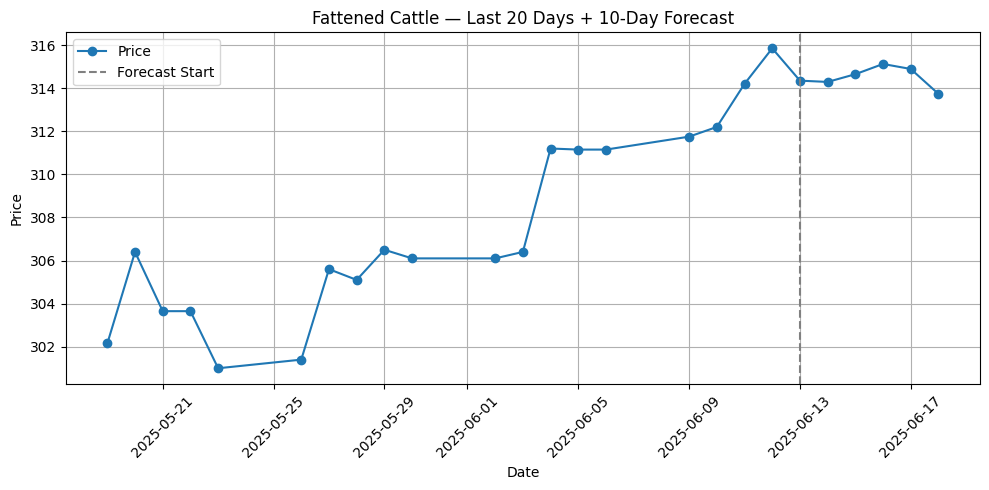


📈 Plotting forecast for: rice


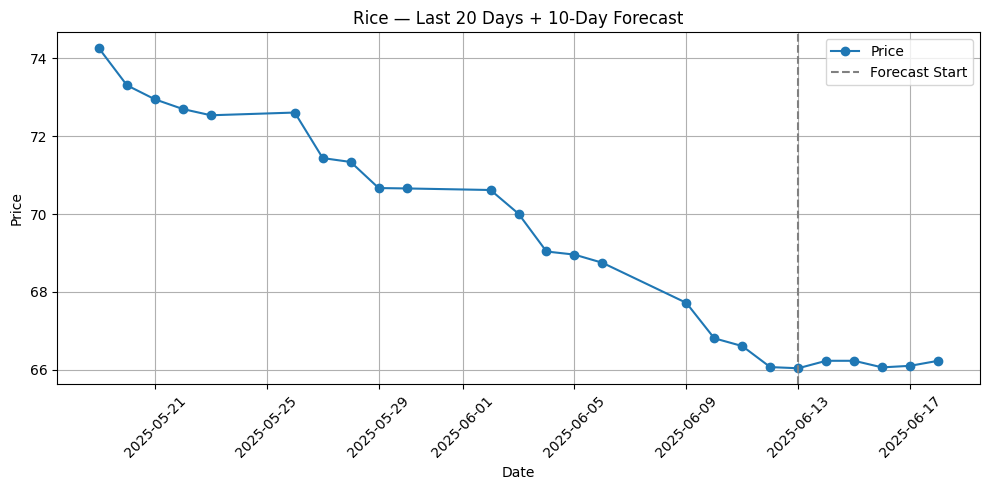


📈 Plotting forecast for: coffee


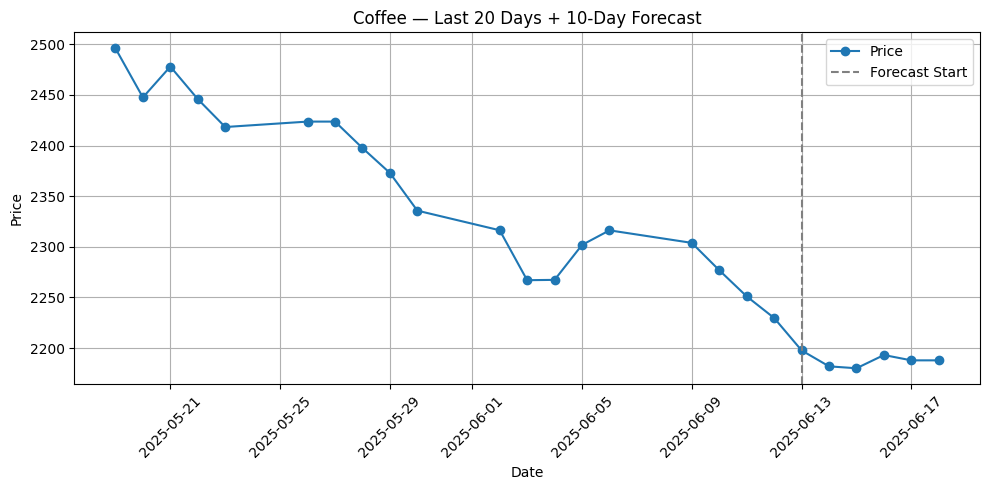

In [ ]:
import matplotlib.pyplot as plt

for name, df in prepared_dfs.items():
    print(f"\n📈 Plotting forecast for: {name}")
    
    model = xgb_results[name]['model']
    features = ['dollar', 'y_lag_1', 'y_lag_2', 'y_lag_3', 'day_of_week', 'month']

    # Sort by date and copy
    df_plot = df.sort_values('ds').copy()

    # Get last 20 actual values for plotting
    df_recent = df_plot.tail(20)[['ds', 'y']].copy()

    # Prepare for forecasting next 5 days
    future_dates = pd.date_range(start=df_plot['ds'].max() + pd.Timedelta(days=1), periods=5)
    future_predictions = []

    # Use the last 3 actual y values as lags
    last_ys = df_plot['y'].tail(3).tolist()[::-1]  # reverse to match lag order: y(t-1), y(t-2), y(t-3)
    dollar_value = df_plot['dollar'].iloc[-1]

    for date in future_dates:
        X_input = pd.DataFrame([{
            'dollar': dollar_value,
            'y_lag_1': last_ys[0],
            'y_lag_2': last_ys[1],
            'y_lag_3': last_ys[2],
            'day_of_week': date.dayofweek,
            'month': date.month
        }])

        # Predict next value
        y_next = model.predict(X_input)[0]
        future_predictions.append((date, y_next))

        # Update lags
        last_ys = [y_next] + last_ys[:2]

    # Assemble prediction DataFrame
    future_df = pd.DataFrame(future_predictions, columns=['ds', 'y'])

    # Combine past and future for plotting
    plot_df = pd.concat([df_recent, future_df], ignore_index=True)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(plot_df['ds'], plot_df['y'], marker='o', label='Price')
    plt.axvline(x=df_recent['ds'].iloc[-1], color='gray', linestyle='--', label='Forecast Start')
    plt.title(f'{name.replace("_", " ").title()} — Last 20 Days +  5-Day Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
